# Generic equivalent layer applied to gravity data

### Brief description

This Jupyter notebook is a supplementary material contaning the code needed to generate part of the synthetic data and reproduce part of the figures and results of this course. This code uses the open-source Python toolkit for geophysical modeling and inversion [Fatiando a Terra](http://www.fatiando.org/index.html).

This code presents the application of an undulating equivalent layer formed by dipoles for the purpose of processing gravity disturbance data. The estimated equivalent layer is saved as a pickle file in `results`.

**Note:** A Jupyter notebook is a document that incorporates text, results, figures, and the Python source code to produce them. If you are viewing this from the URL https://nbviewer.jupyter.org/, the document will be static (not executable). To run the code, you will need to download the notebook and install all the required dependencies. For installing the Fatiando a Terra and all the required dependencies, please follow the instructions shown in http://www.fatiando.org/install.html.

### Import the required dependencies

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import cPickle as pickle
import datetime
from IPython.display import Markdown as md
from IPython.display import display as dp
import string as st

from __future__ import division
from future.builtins import super

import auxiliary_functions as af

from fatiando import gridder
from fatiando.mesher import Prism, PointGrid
from fatiando.gridder import regular

#from fatiando.gravmag import prism, sphere
from fatiando.gravmag import _prism_numpy as prism
from fatiando.gravmag import _sphere_numpy as sphere

#from fatiando.gravmag.eqlayer import EQLTotalField
from fatiando.gravmag._eqlayer_numpy import EQLTotalField

from fatiando.inversion.regularization import Damping, Smoothness2D
from fatiando.inversion.hyper_param import LCurve
from fatiando.vis import mpl, myv
from fatiando.utils import ang2vec, vec2ang, contaminate
from fatiando.constants import G, SI2MGAL, SI2EOTVOS

In [2]:
plt.rcParams['font.size'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['legend.fontsize'] = 6
plt.rcParams['xtick.major.pad'] = 3
plt.rcParams['ytick.major.pad'] = 3

In [3]:
notebook_name = 'generic_eqlayer_grav.ipynb'

In [4]:
saved_files = [] #list of saved files

### Load the synthetic model formed by two rectangular prisms

In [5]:
with open('results\\model.pickle') as f:
        full_model = pickle.load(f)

In [6]:
inc, dec = full_model['geomag_field']

In [7]:
inc = 60.

In [8]:
ints, incs, decs = vec2ang(full_model['model'][0].props['magnetization'])

In [9]:
rhos = full_model['model'][0].props['density']

### Load the grid of points

In [10]:
with open('results\\airborne_survey.pickle') as f:
        grid = pickle.load(f)

In [11]:
grid

{'DS': 260793.97276151844,
 'N': 3600,
 'area': [0, 30000, 5000, 35000],
 'metadata': 'Generated by computation_points.ipynb on 19 October 2016 19:29:19 UTC',
 'shape': (120, 30),
 'spacing': [252.10084033613447, 1034.4827586206898]}

### Define the coordinates on the observation surface

In [12]:
#coordinates x and y of the data
xp, yp = regular(grid['area'], grid['shape'])

#vertical coordinates of the data
zp = af.observation_surface(xp,yp)

### Observed gravity disturbance

Gravity disturbance (equation 1) produced by the synthetic prisms (Figure 3) at the `airborne_survey` points on the undulating surface (Figure 4a). This anomaly is contaminated with a pseudo-random Gaussian noise having null mean and standard deviation equal to $0.5$ mGal.

In [13]:
gz_noise = 0.5

In [14]:
gz = contaminate(prism.gz(xp,yp,zp,full_model['model']), gz_noise, seed=18)

### Gravity disturbance at a planar surface located above

Noise-free gravity disturbance produced by the synthetic prisms (Figure 3) at the `airborne_survey` points on the horizontal plane located at z = -1400 m.

In [15]:
z_up = np.zeros_like(zp) - 1400.0

In [16]:
gz_up = prism.gz(xp,yp,z_up,full_model['model'])

### Undulating equivalent layer

#### Parameters defining the equivalent layer

In [17]:
#undulating surface containing the equivalent sources

h = 1200.
z0 = zp + h

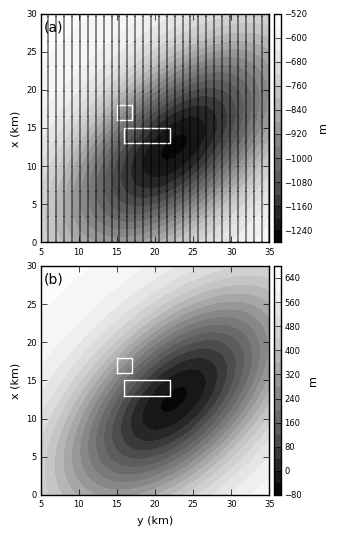

In [18]:
#file_name = 'figs\\Fig10'

nplots = 2

f, (ax1, ax2) = plt.subplots(nplots,figsize=(3.33333,nplots*2.66667))

af.multiplotmap(ax1, xp, yp, zp, grid['shape'], grid['area'],
                color_scheme = 'Greys_r', prism_projection = True, projection_style = '-w', 
                model = full_model['projection'], unit = 'm',
                figure_label = '(a)', label_x = False,
                observations=True, point_style='.k', point_size=1)

af.multiplotmap(ax2, xp, yp, z0, grid['shape'], grid['area'],
                color_scheme = 'Greys_r', prism_projection = True, projection_style = '-w', 
                model = full_model['projection'], unit = 'm', 
                figure_label = '(b)')

#plt.savefig(file_name+'.eps', dpi=600)
#saved_files.append(file_name+'.eps')

plt.show()

#### Estimated physical-property distribution

Linear inverse problem for estimating the physical property distribution within the equivalent layer. A previously estimated equivalent layer may be saved at the directory `results` as a pickle file named `inversion_notebookname.pickle`. Execute the cell below to check if this file exists. If this file does not exist, an IOError will be raised. In this case, you will need to run the inversion. To do this, you need first transform the following 17 cells from `Raw NBConvert` to `Code` and execute them.

In [19]:
#equivalent layer
layer = PointGrid(grid['area'], z0, grid['shape'])

In [20]:
# misfit function
misfit = EQLTotalField(xp, yp, zp, gz, inc, dec, layer, sinc=inc, sdec=dec)

In [21]:
# normalizing factor
f0 = np.trace(misfit.hessian(None))/misfit.nparams

In [22]:
print 'f0 = %10.3e' % f0

f0 =  6.928e-14


In [23]:
# Tikhonov regularization
#regul = Damping(layer.size)
regul = Smoothness2D(layer.shape)

In [24]:
# Use the L-curve to find the best regularization parameter
solver = LCurve(misfit, regul, [f0*(10.**i) for i in range(-10, -1)]).fit()

In [25]:
print 'u0 = %10.3e' % ((1./f0)*solver.regul_param_)

u0 =  1.000e-02


In [26]:
layer.addprop('magnetization', solver.estimate_)

In [27]:
predicted = solver[0].predicted()

In [28]:
estimate = solver.estimate_

In [29]:
residuals = solver[0].residuals()

#### Save the results

In [30]:
inversion = dict() #empty dictionary

In [31]:
now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
inversion['metadata'] = 'Generated by {name} on {date}'.format(date=now, name=notebook_name)

In [32]:
inversion['layer'] = layer

In [33]:
inversion['predicted'] = solver[0].predicted()

In [34]:
inversion['estimate'] = solver.estimate_

In [35]:
#save the inversion results by using the Python pickle module (https://docs.python.org/2/library/pickle.html)
file_name = 'results\\inversion_%s.pickle' % notebook_name[:st.index(notebook_name,'.')]
with open(file_name, 'w') as f:
    pickle.dump(inversion, f)
saved_files.append(file_name)

#### Data fit

#### Comparison between the true and predicted gravity disturbance at the plane -1400 m

In [36]:
# predicted gravity disturbance
gz_up_pred = sphere.tf(xp, yp, z_up, layer, inc, dec)

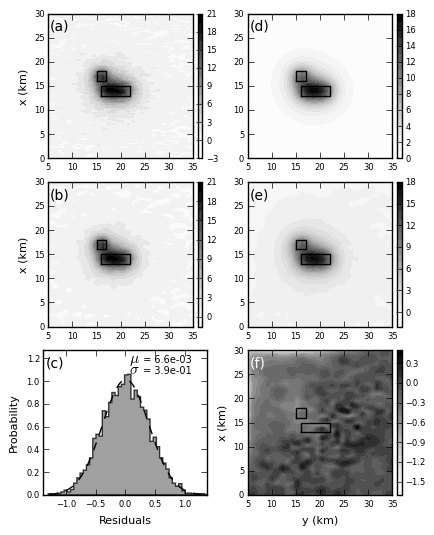

In [37]:
#file_name = 'figs\\Fig11'

f, ax = plt.subplots(3,2,figsize=(4.33333,2*2.66667))

af.multiplotmap(ax[0][0], xp, yp, gz, grid['shape'], grid['area'], 
                color_scheme = 'Greys',
                prism_projection = True, projection_style = '-k', 
                model = full_model['projection'], ranges = af.scale_bounds(gz),
                figure_label = '(a)', label_position = (0.02,0.89), label_x = False)

af.multiplotmap(ax[1][0], xp, yp, predicted, grid['shape'], grid['area'], 
                color_scheme = 'Greys',
                prism_projection = True, projection_style = '-k', 
                model = full_model['projection'], ranges = af.scale_bounds(gz),
                figure_label = '(b)', label_position = (0.02,0.89), label_x = False)

af.multiplothist(ax[2][0], residuals, text_position = [0.52, 0.92, 0.84, 0.07],
                 text_fontsize = 7,
                 figure_label = '(c)', label_position = (0.02,0.89))

af.multiplotmap(ax[0][1], xp, yp, gz_up, grid['shape'], grid['area'], 
                color_scheme = 'Greys',
                prism_projection = True, projection_style = '-k', 
                model = full_model['projection'], 
                figure_label = '(d)', label_position = (0.02,0.89), label_x = False, label_y = False)

af.multiplotmap(ax[1][1], xp, yp, gz_up_pred, grid['shape'], grid['area'], 
                color_scheme = 'Greys',
                prism_projection = True, projection_style = '-k', 
                model = full_model['projection'], 
                figure_label = '(e)', label_position = (0.02,0.89), label_x = False, label_y = False)

af.multiplotmap(ax[2][1], xp, yp, gz_up_pred - gz_up, grid['shape'], grid['area'],
                color_scheme = 'Greys',
                prism_projection = True, projection_style = '-k', 
                model = full_model['projection'],
                figure_label = '(f)', label_color = 'w',
                label_position = (0.02,0.89))

plt.tight_layout()

#plt.savefig(file_name+'.eps', dpi=600)
#saved_files.append(file_name+'.eps')

plt.show()

### Saved files

In [38]:
with open('reports\\report_%s.md' % notebook_name[:st.index(notebook_name,'.')], 'w') as f:
    f.write('# Saved files \n')
    f.write('\n\n'+inversion['metadata']+'\n\n')
    f.write('*  `results\\inversion_%s.pickle`' % notebook_name[:st.index(notebook_name,'.')])
    now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
    header = '\nGenerated by {name} on {date}'.format(date=now, name=notebook_name)
    f.write('\n\n'+header+'\n\n')
    for i, sf in enumerate(saved_files):
        print '%d  %s' % (i+1,sf)
        f.write('*  `%s` \n' % (sf))

1  results\inversion_generic_eqlayer_grav.pickle
